<a href="https://colab.research.google.com/github/megannguyen6898/DATA-5710-Megan-Nguyen/blob/main/DATA5710_Assignment_3_Kalman_Filter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DATA5710 - Assignment 3

## Time Series and Longitudinal Models, State Space Models and Random Effects

**Semester 1, 6 April 2021**



Lecturers and Tutors: Robert Kohn and Gilad Francis

## Background Description

We are building an aircraft tracking system using a Kalman filter.

Below you can find a simulator that update the state of the tracked object and provide noisy observations:
1. The simulator internal state such as the TRUE speed and location of the object are unknown to you.
2. Observations of object are distance and direction from a given observation location (label as observer_coords).

Exercise 1 - Constant speed, changing direction, normal noise location model:
Code a Kalman filter that returns an estimate of the object location. Add the Filter update to loop (replace "TODO")
Make whatever assumptions you deem necessary commenting on the justifications.
You are encouraged to re-use most of the code from the tutorials and deliver this python notebook as a completed file
with your analysis.
Note that for Exercise #1, you can as

Exercise 2 - Constant speed, changing direction:
Similar to #1, however normal noise is added to direct observations (distance and angle).
2.a Explain the difference in noise mechanism
2.b Compare your filter performance in this scenario. What are the difference (if
 any) and why. (no change required in your filter code).

Exercise 3:
The tracked object can accelerate!
Compare your filter performance in this scenario. What are the difference (if any) and why.
What changes to the filter would improve the performance? (no need to code changes)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
class simulator(object):

    def __init__(self, d_noise=0.3, theta_noise=0.2, acceleration_sigma=0.1,
                 accelerate=False, noise_type='normal'):

        self.p_ = np.random.randn(2,)
        self.v_ = 0.5 + 0.5*np.random.rand(1)
        self.a_ = 0.1 + 0.1*np.random.rand(1)
        self.a_sigma = acceleration_sigma
        self.theta_ = np.pi * np.random.rand(1)

        self.d_noise_ = d_noise
        self.coord_noise_ = d_noise/3
        self.theta_noise_ = theta_noise*np.pi/180.
        self.acc_ = accelerate
        self.noise_type_ = noise_type

    def true_p(self):
        return self.p_.copy()

    def observe(self, observer_p = np.array([-5.,-5.])):
        #Assumes an observer

        if self.noise_type_=='distance':

            obs_vec = self.p_ - observer_p
            d_ = np.linalg.norm(obs_vec)
            d_obs = np.random.normal(d_, self.d_noise_)
            d_obs = np.clip(d_obs, 0.1, None)  #prevent negative values
            angle_ = np.arctan2(obs_vec[1], obs_vec[0])
            angle_obs = np.random.normal(angle_, self.theta_noise_)
        elif self.noise_type_=='normal':

            p_observed = np.random.normal(self.p_, self.coord_noise_)
            obs_vec = p_observed - observer_p
            d_obs =  np.linalg.norm(obs_vec)
            angle_obs = np.arctan2(obs_vec[1], obs_vec[0])

        else:
            raise ValueError(f'Undefined noise model {self.noise_type_}')
        return d_obs, angle_obs

    def step(self, dt=1.):

        self.theta_ += np.pi/30.*np.random.randn(1)
        v = np.array([self.v_*np.cos(self.theta_), self.v_*np.sin(self.theta_)]).squeeze()
        self.p_ += v * dt
        if self.acc_:
            #Resample acceleration
            self.a_ += self.a_sigma*np.random.randn(1)
            self.v_ += self.a_*dt
            self.p_ += 0.5*self.a_*dt*dt


In [ ]:
def kalman_gain(P, C, sigma):
    K_n = P.dot(C.transpose()).dot(
        np.linalg.inv(
            C.dot(P).dot(C.transpose()) + sigma
        )
    )
    return K_n

##P is mean squared error of true locations (coords) at time t given observations of direction and angle (observer_coords)
#C is relationship between unknown state and observations
#sigma is the noise when we predict the angle and directions from the true location 

In [ ]:
def kalman_predict(mu, V, A, gamma, drift):
    #mu and V are the mean and variance of previous state, drfit from t-1 to t, given observations at time t-1
    #mu_p is the mean of state at time t given the observations at time t-1
    #A is to update unknown state to time t
    #gamma is noise of variance of true location at previous time t-1
    #drift is noise of true location at previous time t-1
    mu_p = A.dot(mu) + drift
    P_p = np.diag(
        np.diag(
            A.dot(V).dot(A.transpose())
        )
    ) + gamma
    return mu_p, P_p

In [ ]:
def kalman_update(x_n, mu_p, P_p, C, sigma):
    #mu_p and P_p are the mean and variance of observations (observer_coords) after we predict the unknown state at time t
    #mu_n is the updated mean of unknowne state at time t given observations at time t
    K_n = kalman_gain(P_p, C, sigma)
    mu_n = x_n + K_n.dot(mu_p - C.dot(x_n))
    V_n = P_p - K_n.dot(C).dot(P_p)
    return mu_n, V_n

Text(0.5, 1.0, 'Exercise 1 - Noise on pose')

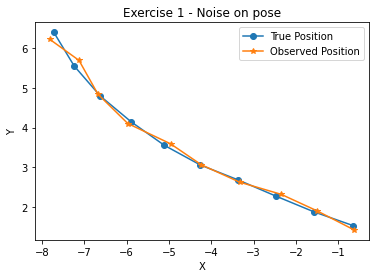

In [ ]:
#Exercise 1
#Constant speed, changing direction  - Normal noise in location

sim = simulator()
observer_coords = np.array([-5.,-5.])
V = np.identity(2)*0.2 #variance of previous state 
A = np.identity(2) #to update step at time t-1
C = np.identity(2) #the relationship between unknown state and observations
coords = [] 
coords_obs = []
estimations = [] #kalman filter predictions
for i in range(10):

    drift = sim.step(self.p_)
    x_n = coords.append(sim.true_p()) #true location (unknown state) at time t-1
    d_obs, angle_obs = sim.observe(noise_type_=='normal',observer_coords)

    v_sigma = 0 
    sigma = C * v_sigma #since we only consider noise in true location
    gamma = coord_noise #since this reflects the noise of true location
    
    #let observer_p be the location at time t-1 given observations at time t-1
    #we use kalman filter to predict observations at time t from unknown state we predict at time t
    obs_p, var_p = kalman_predict(observer_p, V, A, drift, gamma)
    #true location at time t-1
    Z_t = coords[i].transpose()
    Z_t = Z_t.reshape(Z_t.shape[0], -1)
    #we update the unknown state at time t given observations at time t and true location of t-1
    obs_t, var_t = kalman_update(obs_p, Z_t, var_p, C, sigma)
    
    obs_p=obs_t
    var_p=var_t
    estimations.append(obs_p.transpose())
    
coords = np.asarray(coords).squeeze()
coords_obs = np.asarray(coords_obs).squeeze()
estimations = np.vstack(estimations)
pl.plot(estimations[:,0], estimations[:,1], 'X-', color='g', label='Kalman Filter')
plt.plot(coords[:,0], coords[:,1], 'o-',  label='True Position')
plt.plot(coords_obs[:,0], coords_obs[:,1], '*-', label='Observed Position')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.title('Exercise 1 - Noise on location')
#Todo: plt Kalman filter estimates

Text(0.5, 1.0, 'Exercise 2 - Noise on distance and angle observations')

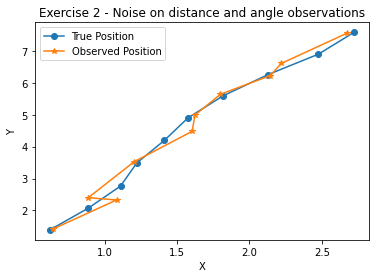

In [ ]:
#Exercise 2
#Constant speed, changing direction  (same as Exercise 1) -
# Normal noise on distance and angle observations

sim2 = simulator(noise_type='distance')
observer_coords = np.array([-5.,-5.])
V = np.identity(2)*0.2 #variance of previous state 
A = np.identity(2) #to update step at time t-1
C = np.identity(2) #the relationship between unknown state and observations

coords = []
coords_obs = []
estimations = [] #kalman filter predictions

for i in range(10):

    drfit = sim2.step(self.p_)
    x_n = coords.append(sim2.true_p())

    d_obs, angle_obs = sim2.observe(noise_type_=='distance',observer_coords)

    v_sigma = theta_noise #since this reflects noise in direction
    sigma = C * v_sigma 
    gamma = 0 #since we no longer consider the noise of true location
    
    #let observer_p be the location at time t-1 given observations at time t-1
    #we use kalman filter to predict observations at time t from unknown state we predict at time t
    obs_p, var_p = kalman_predict(observer_p, V, A, drift, gamma)
    #true location at time t-1
    Z_t = coords[i].transpose()
    Z_t = Z_t.reshape(Z_t.shape[0], -1)
    #we update the unknown state at time t given observations at time t and true location of t-1
    obs_t, var_t = kalman_update(obs_p, Z_t, var_p, C, sigma)
    
    obs_p=obs_t
    var_p=var_t
    estimations.append(obs_p.transpose())

coords = np.asarray(coords).squeeze()
coords_obs = np.asarray(coords_obs).squeeze()
estimations = np.vstack(estimations)
pl.plot(estimations[:,0], estimations[:,1], 'X-', color='g', label='Kalman Filter')
plt.plot(coords[:,0], coords[:,1], 'o-',  label='True Position')
plt.plot(coords_obs[:,0], coords_obs[:,1], '*-', label='Observed Position')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.title('Exercise 2 - Noise on distance and angle observations')
#Todo: plt Kalman filter estimates

Text(0.5, 1.0, 'Exercise 3 - Acceleration')

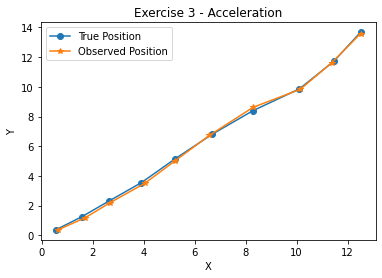

In [ ]:
#Exercise 3. Acceleration
#If tracked object accelerates, we need to account for the changes in true speed by accounting for acceleration in step for the true state

sim3 = simulator(accelerate=True)
observer_coords = np.array([-5.,-5.])
V = np.identity(2)*0.2 #variance of previous state 
A = np.identity(2) #to update step at time t-1
C = np.identity(2) #the relationship between unknown state and observations

coords = []
coords_obs = []
estimations = [] #kalman filter predictions

for i in range(10):

    drfit = sim3.step(self.acc_)
    x_n = coords.append(sim3.true_p())

    d_obs, angle_obs = sim3.observe(observer_coords)

#Since object accelerates, there will be noise in both observations and true location
    v_sigma = theta_noise #since this reflects noise in direction
    sigma = C * v_sigma 
    gamma = coord_noise
    
    #let observer_p be the location at time t-1 given observations at time t-1
    #we use kalman filter to predict observations at time t from unknown state we predict at time t
    obs_p, var_p = kalman_predict(observer_p, V, A, drift, gamma)
    #true location at time t-1
    Z_t = coords[i].transpose()
    Z_t = Z_t.reshape(Z_t.shape[0], -1)
    #we update the unknown state at time t given observations at time t and true location of t-1
    obs_t, var_t = kalman_update(obs_p, Z_t, var_p, C, sigma)
    
    obs_p=obs_t
    var_p=var_t
    estimations.append(obs_p.transpose())


coords = np.asarray(coords).squeeze()
coords_obs = np.asarray(coords_obs).squeeze()
estimations = np.vstack(estimations)
pl.plot(estimations[:,0], estimations[:,1], 'X-', color='g', label='Kalman Filter')
plt.plot(coords[:,0], coords[:,1], 'o-',  label='True Position')
plt.plot(coords_obs[:,0], coords_obs[:,1], '*-', label='Observed Position')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.title('Exercise 3 - Acceleration')